In [3]:
import pandas as pd
from collections import Counter
import pickle as pkl
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scipy.stats as stats

## Load Data
delete short sentences

In [2]:
header = ['ID', 'timestamp', 'Day_of_Week', 'State', 'Tweet', 'mentioned_food',
         'mentioned_activity', 'target', 'distance_1_food','distance_1_activity',
          'distance_2_food','distance_2_activity','distance_3_food','distance_3_activity',
          'distance_4_food','distance_4_activity']
df1 = pd.read_csv("./2015-06.csv",index_col=False, header=None, names=header)
df2 = pd.read_csv("./2015-11.csv",index_col=False, header=None, names=header)
df = pd.concat((df1,df2),axis=0)

In [11]:
lst = []
for i,sentence in enumerate(df['Tweet']):
    try:
        if len(sentence.split(' ')) > 4:
            lst.append(i)
    except:
        continue
df = df.iloc[lst]

In [3]:
with open('./df_distance.pickle','rb') as input_file:
    df = pkl.load(input_file)
print(df.shape)
df.head()

(7316773, 16)


,ID,timestamp,Day_of_Week,State,Tweet,mentioned_food,mentioned_activity,target,distance_1_food,distance_1_activity,distance_2_food,distance_2_activity,distance_3_food,distance_3_activity,distance_4_food,distance_4_activity
0,605161837743755264,1.433131e+09,Monday,1,wind 00 mph barometer 3007 rise temperature 69...,NaN,NaN,0,4.908694,4.203416,6.523432,5.319320,5.730753,5.727139,5.730753,5.585906
1,605161838318370816,1.433131e+09,Monday,47,great group guy celebrate wonderful marriage c...,NaN,NaN,0,3.742134,2.865506,5.024673,4.983678,5.742434,5.486623,5.742434,5.047871
2,605161839165599744,1.433131e+09,Monday,54,i push acre i moment,NaN,NaN,0,3.879306,2.970662,5.109738,5.038453,6.311631,5.882600,5.815228,5.603898
3,605161840193204224,1.433131e+09,Monday,12,temp 847 f humidity 77 wind sse 31 mph bar...,NaN,NaN,0,5.641654,5.089753,7.516935,6.076470,7.589442,6.342270,6.915214,6.342270
4,605161841879330817,1.433131e+09,Monday,10,temp 831f wc 831f wind 42 mph s gust 100 mph b...,NaN,NaN,0,4.061290,3.421374,6.292171,4.948800,6.131165,5.727139,5.581165,5.678833


In [25]:
set(df['target'])

{0, 1, 2, 3}

In [138]:
pkl.dump(df, open('df_distance.pickle','wb'))

In [5]:
with open('df_distance.pickle','rb') as input_file:
    df = pkl.load(input_file)

## Functions

In [6]:
def feed_lda(num_topics,max_features,max_df,df):
    # load tf_vectorizer and lda model
    tf_path = 'data/tfVectorizer_topics={}_maxFeatures={}_maxDf={}_minDf=1.pickle'.format(num_topics,max_features,max_df)
    lda_path = 'data/LDA_topics={}_maxFeatures={}_maxDf={}_minDf=1.pickle'.format(num_topics,max_features,max_df)
    name = "topics={}_maxFeatures={}_maxDf={}".format(num_topics,max_features,max_df)
    if (os.path.exists(tf_path)) & ( os.path.exists(lda_path)):
        with open(tf_path,'rb') as input_file:
            tf_vectorizer = pkl.load(input_file)
        with open(lda_path, "rb") as input_file:
            lda = pkl.load(input_file)
            
    # predicts probs of text using lda
    start = time.time()
    probs = lda.transform(tf_vectorizer.transform(df['Tweet'].tolist()))
    X = pd.concat((df,pd.DataFrame(probs)),axis=1)
    
    return probs, X['target']

In [111]:
def plot_distance(name,distance_1,distance_2,distance_3,distance_4,probabilities,step=100000):
    plt.close('all')
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('sample')
    ax1.set_ylabel('distance')
    ax2 = ax1.twinx()
    ax2.set_ylim([0,1])
    ax2.set_ylabel('probabilities')
    
    d1, d2, d3, d4, p = [], [], [], [], []
    for i in range(0,len(probabilities),step):
        d1.append(distance_1[i])
        d2.append(distance_2[i])
        d3.append(distance_3[i])
        d4.append(distance_4[i])
        p.append(probabilities[i])
        
    ax1.plot(d1,label='d1',color='deepskyblue')
    ax1.plot(d2,label='d2',color='skyblue')
    ax1.plot(d3,label='d3',color='lightskyblue')
    ax1.plot(d4,label='d4',color='blue')
    ax2.plot(p,label='probs',color='red')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    plt.title(name)
    plt.savefig(name+'.png')
    plt.show()

In [112]:
def plot_probs(name,distance_1,distance_2,distance_3,distance_4,probabilities,step=100000):
    plt.close('all')
    plt.xlabel('probabilities')
    plt.ylabel('distance')    
    
    d1, d2, d3, d4, p = [], [], [], [], []
    for i in range(0,len(probabilities),step):
        d1.append(distance_1[i])
        d2.append(distance_2[i])
        d3.append(distance_3[i])
        d4.append(distance_4[i])
        p.append(probabilities[i])
        
    plt.plot(p,d1,label='d1',color='deepskyblue')
    plt.plot(p,d2,label='d2',color='skyblue')
    plt.plot(p,d3,label='d3',color='lightskyblue')
    plt.plot(p,d4,label='d4',color='blue')
    plt.legend()
    plt.title(name)
    plt.savefig(name+'.png')
    plt.show()

## Food

### data

In [13]:
df1 = df.replace(3,1).replace(2,0).reset_index(drop=True)
Counter(df1['target'])

Counter({0: 6855838, 1: 460935})

### model

In [9]:
with open('./best_model_food.pickle','rb') as input_file:
    model_food = pkl.load(input_file)
print(model_food.classes_)
model_food

[0 1]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### lda results   
y_true: true class

In [14]:
%%time
X1, y1_true = feed_lda(125, 25000, 0.5, df1)

CPU times: user 10min 25s, sys: 1min 26s, total: 11min 52s
Wall time: 12min 2s


In [15]:
set(y1_true)

{0, 1}

### rf predicted results  
y: probabilities of all classes  
y_probs: probabilities of food/activity   

In [16]:
%%time
y1 = model_food.predict_proba(X1)
y1_probs = [y[1] for y in y1]

CPU times: user 7min 52s, sys: 14.9 s, total: 8min 7s
Wall time: 1min 15s


y_preds: predicted class

In [17]:
%%time
y1_preds = model_food.predict(X1)

CPU times: user 7min 34s, sys: 16.1 s, total: 7min 50s
Wall time: 1min 12s


accuracy

In [18]:
sum(y1_preds==y1_true)/len(y1_true)

0.7702656621983489

### confusion matrix

In [19]:
# confusion matrix
conf_mat1 = confusion_matrix(y1_true, y1_preds)
conf_mat1
# TN FP
# FN TP

array([[5226581, 1629257],
       [  51657,  409278]])

In [90]:
TN, FP, FN, TP = [], [], [], []
n = 1000
for i in range(len(y1_true)):
    if y1_true[i]==0 and y1_preds[i]==0 and len(TN)<n:
        TN.append(df1['Tweet'][i])
    elif y1_true[i]==0 and y1_preds[i]==1 and len(FP)<n:
        FP.append(df1['Tweet'][i])
    elif y1_true[i]==1 and y1_preds[i]==0 and len(FN)<n:
        FN.append(df1['Tweet'][i])
    elif y1_true[i]==1 and y1_preds[i]==1 and len(TP)<n:
        TP.append(df1['Tweet'][i])
    if len(TN)>= n and len(FP)>=n and len(FN)>=n and len(TP)>=n:
        break

In [107]:
FP[:10]

['temperature 49  f gt 48  f humidity 61 gt 80 wind 7 mph gt 5 mph pressure 3003 fall',
 'wind 40 mph sse barometer 30026 fall temperature 586  f rain today 000 humidity 60',
 'wind 00 mph barometer 101819 mb rise temperature 448  f rain today 000 humidity 98',
 '648f feel 648f humidity 99 wind 54 mph e gust 69 mph pressure 10141 mb rain 038',
 'wind 00 mph w barometer 29957 fall slowly temperature 639  f rain today 000 humidity 92',
 'wind 40 mph s barometer 30032 fall temperature 585  f rain today 000 humidity 60',
 'temp 340  f gust 18 mph gust direction se cloud base 8386 ft pressure 2972inhg rainfall rate 000in hr rain today 000',
 'temperature 72  f gt 63  f humidity 55 gt 58 wind 0 mph gt 3 mph',
 'temperature 83  f gt 67  f humidity 23 gt 33 pressure 3002 fall',
 'temperature 53  f gt 51  f wind 6 mph gt 12 mph pressure 2975 rise']

Increase the threshold to 0.8

In [20]:
y1_preds_new = [1 if y1_probs[i]>0.8 else 0 for i in range(len(y1_probs))]
conf_mat1_new = confusion_matrix(y1_true, y1_preds_new)
conf_mat1_new

array([[6516375,  339463],
       [ 213070,  247865]])

In [21]:
#acc
sum(y1_preds_new==y1_true)/len(y1_true)

0.9244840587510368

In [91]:
TN_new, FP_new, FN_new, TP_new = [], [], [], []
n = 1000
for i in range(len(y1_true)):
    if y1_true[i]==0 and y1_preds_new[i]==0 and len(TN_new)<n:
        TN_new.append(df1['Tweet'][i])
    elif y1_true[i]==0 and y1_preds_new[i]==1 and len(FP_new)<n:
        FP_new.append(df1['Tweet'][i])
    elif y1_true[i]==1 and y1_preds_new[i]==0 and len(FN_new)<n:
        FN_new.append(df1['Tweet'][i])
    elif y1_true[i]==1 and y1_preds_new[i]==1 and len(TP_new)<n:
        TP_new.append(df1['Tweet'][i])
    if len(TN_new)>= n and len(FP_new)>=n and len(FN_new)>=n and len(TP_new)>=n:
        break

In [108]:
FP_new[:10]

['wind 00 mph barometer 101819 mb rise temperature 448  f rain today 000 humidity 98',
 'temp 340  f gust 18 mph gust direction se cloud base 8386 ft pressure 2972inhg rainfall rate 000in hr rain today 000',
 'temperature 53  f gt 51  f wind 6 mph gt 12 mph pressure 2975 rise',
 'cloudy gt cloudy temperature 54  f gt 56  f humidity 97 gt 90 wind 0 mph gt 8 mph',
 'temp 660  f wind00 mph pressure 29908hpa steady rain today 002',
 'temperature 77  f gt 64  f humidity 22 gt 34 wind 3 mph gt 0 mph',
 'temperature 74  f gt 64  f humidity 64 gt 56 wind 6 mph gt 0 mph',
 'cloudy gt shower temperature 56  f gt 57  f humidity 90 gt 100 wind 6 mph gt 3 mph visibility 10mi gt 4mi',
 'partly cloudy gt fair temperature 47  f gt 45  f humidity 86 gt 90 wind 13 mph gt 12 mph visibility 10mi gt 9mi',
 'wind 00 mph wnw barometer 29945 fall slowly temperature 638  f rain today 000 humidity 92']

In [22]:
df1['probs_food'] = y1_probs
df1['preds_food'] = y1_preds
df1['true_food'] = y1_true

df1 = df1.sort_values(['probs_food']).reset_index(drop=True)
df1.head()

,ID,timestamp,Day_of_Week,State,Tweet,mentioned_food,mentioned_activity,target,distance_1_food,distance_1_activity,distance_2_food,distance_2_activity,distance_3_food,distance_3_activity,distance_4_food,distance_4_activity,probs_food,preds_food,true_food
0,605161837743755264,1.433131e+09,Monday,1,wind 00 mph barometer 3007 rise temperature 69...,NaN,NaN,0,4.908694,4.203416,6.523432,5.319320,5.730753,5.727139,5.730753,5.585906,0.0,0,0
1,660744342248759296,1.446387e+09,Sunday,25,temperature 49 f gt 48 f humidity 61 gt 80 w...,NaN,NaN,0,4.590727,3.755841,6.497299,5.255440,6.467789,5.927032,6.467789,5.145692,0.0,0,0
2,660744338008203264,1.446387e+09,Sunday,6,wind 40 mph sse barometer 30026 fall temperatu...,NaN,NaN,0,4.863321,4.138520,6.592575,5.362590,5.730753,6.178299,5.730753,5.145692,0.0,0,0
3,660744279682338816,1.446387e+09,Sunday,48,temperature 60 f gt 58 f humidity 83 gt 85 w...,NaN,NaN,0,4.586811,3.805616,6.521957,5.222861,6.616901,5.727139,6.365636,5.727139,0.0,0,0
4,660744267078348800,1.446387e+09,Sunday,30,temp 530 f lo temp 496 wind153 mph maxgust wi...,NaN,NaN,0,4.409149,3.715347,6.604475,4.930043,6.616901,5.727139,6.365636,5.727139,0.0,0,0


### distance analysis

- distance vs predicted probabilities: moving average

In [103]:
df2 = df1[['distance_1_food','distance_2_food','distance_3_food','distance_4_food','probs_food']]
df2_ = df2.rolling(1000).mean()[999:].reset_index(drop=True)
df2_.tail()

,distance_1_food,distance_2_food,distance_3_food,distance_4_food,probs_food
7315769,2.826644,4.873584,5.245802,4.514678,1.0
7315770,2.827996,4.874086,5.246690,4.515819,1.0
7315771,2.826549,4.874576,5.246810,4.515833,1.0
7315772,2.828020,4.874133,5.246570,4.516903,1.0
7315773,2.828070,4.874069,5.246607,4.516507,1.0


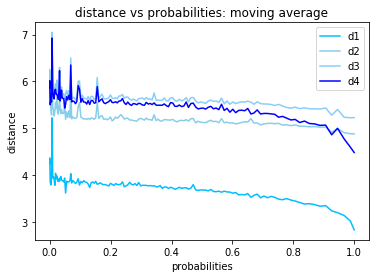

In [113]:
plot_probs('distance vs probabilities: moving average',df2_['distance_1_food'],df2_['distance_2_food'],df2_['distance_3_food'],df2_['distance_4_food'],df2_['probs_food'],step=50000)

- distance group by tweets with or without food

In [101]:
df3 = df1[['distance_1_food','distance_2_food','distance_3_food','distance_4_food','preds_food','true_food']].sort_values(['true_food']).reset_index(drop=True)
df3_ = df3[['distance_1_food','distance_2_food','distance_3_food','distance_4_food']].rolling(1000).mean()[999:].reset_index(drop=True)
df3_ = pd.concat((df3_,df3['true_food'][999:].reset_index(drop=True),df3['preds_food'][999:].reset_index(drop=True)),axis=1)
df3_.tail()

,distance_1_food,distance_2_food,distance_3_food,distance_4_food,true_food,preds_food
7315769,3.029226,4.878992,5.251235,4.654004,1,1
7315770,3.029310,4.877879,5.250860,4.653311,1,1
7315771,3.030440,4.878263,5.250971,4.654440,1,1
7315772,3.029992,4.878056,5.250613,4.653672,1,1
7315773,3.029846,4.878365,5.250807,4.653183,1,1


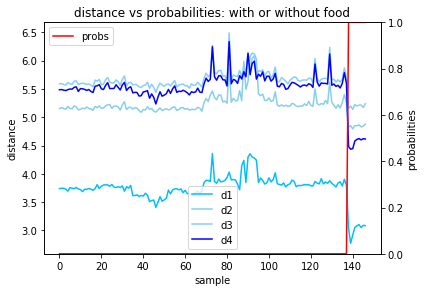

In [114]:
plot_distance('distance vs probabilities: with or without food',df3_['distance_1_food'],df3_['distance_2_food'],df3_['distance_3_food'],df3_['distance_4_food'],df3_['true_food'],step=50000)